In [1]:
import tensorflow as tf
from tensorflow.keras import models, Sequential, regularizers
from tensorflow.keras.layers import Dropout, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation, RandomContrast, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
tf.get_logger().setLevel('ERROR')

C:\Users\prafu\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
input_shape = (IMAGE_SIZE, IMAGE_SIZE)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=r".\Train_Data",
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=input_shape
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
n_classes = len(class_names)
print(f"Number of classes : {n_classes}, classes : {class_names}")

Number of classes : 3, classes : ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


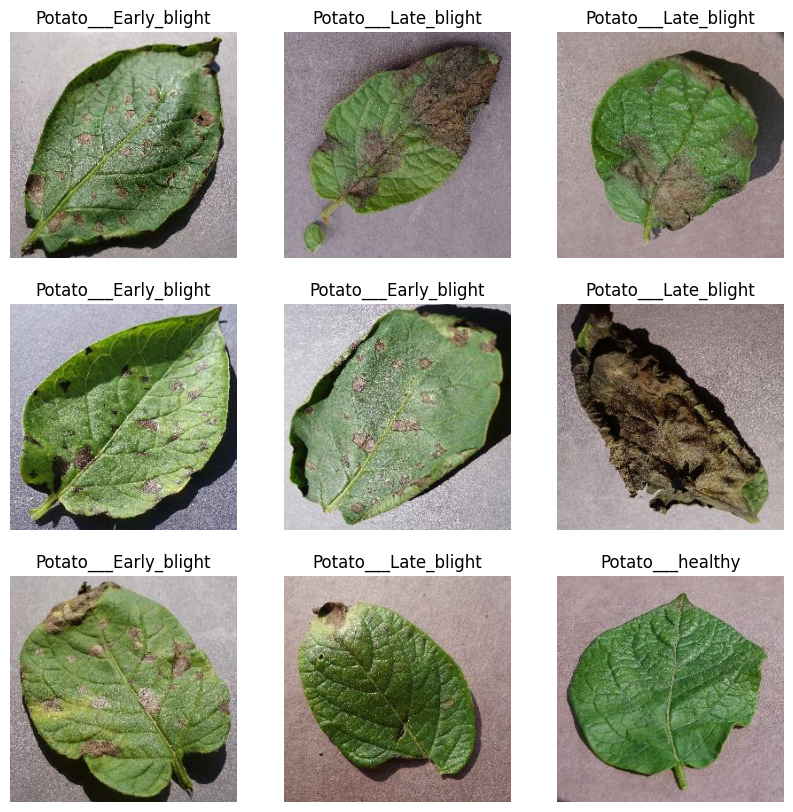

In [5]:
plt.figure(figsize=(10,10))
for image, label in dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,(i+1))
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i].numpy()])
        plt.axis('off')
plt.show()

## Train Test Split
80% ==> Train
10% ==> Validation
10% ==> Test

In [6]:
def train_test_val_split(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    if shuffle:
        ds.shuffle(shuffle_size, seed=12)
    # Initial 80% is our training dataset
    train_ds = ds.take(train_size)
    # Skipping initial 80% batches
    test_ds = dataset.skip(train_size)
    # Next 10% is our validation data
    val_ds = test_ds.take(val_size)
    # Remaining is test dataset
    test_ds = test_ds.skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = train_test_val_split(dataset)

## Data Preprocessing

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

These preprocessing and data augmentation layers will be included in our final model and it becomes part of our model and hence can be included in the exported model

In [9]:
rescale_resize = Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE, input_shape=(256, 256, 3)),
    Rescaling(1.0/255)
])

In [10]:
data_augmentation = Sequential([
    RandomFlip(mode="horizontal_and_vertical"),
    RandomRotation(factor=0.2),
    RandomContrast(factor=0.2)
])

## Model Building

In [141]:
model = Sequential()

model.add(rescale_resize)
model.add(data_augmentation)

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.L2(0.001)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.L2(0.001)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.L2(0.001)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.L2(0.001)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.L2(0.001)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.L2(0.001)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

In [142]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 sequential_18 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_65 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [143]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [144]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5)

In [145]:
history = model.fit(train_ds, epochs=30, batch_size=BATCH_SIZE, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/30
47/47 [==============================] - 28s 446ms/step - loss: 1.0789 - accuracy: 0.4834 - val_loss: 1.0096 - val_accuracy: 0.4784
Epoch 2/30
47/47 [==============================] - 20s 420ms/step - loss: 0.9306 - accuracy: 0.5372 - val_loss: 0.8064 - val_accuracy: 0.6298
Epoch 3/30
47/47 [==============================] - 20s 429ms/step - loss: 0.7416 - accuracy: 0.6908 - val_loss: 0.7580 - val_accuracy: 0.6995
Epoch 4/30
47/47 [==============================] - 20s 419ms/step - loss: 0.5600 - accuracy: 0.7892 - val_loss: 0.6176 - val_accuracy: 0.7885
Epoch 5/30
47/47 [==============================] - 20s 417ms/step - loss: 0.4487 - accuracy: 0.8344 - val_loss: 0.4171 - val_accuracy: 0.8678
Epoch 6/30
47/47 [==============================] - 20s 422ms/step - loss: 0.3371 - accuracy: 0.8896 - val_loss: 0.3053 - val_accuracy: 0.9087
Epoch 7/30
47/47 [==============================] - 20s 423ms/step - loss: 0.2801 - accuracy: 0.9089 - val_loss: 0.3712 - val_accuracy: 0.8798

## Model Evaluation

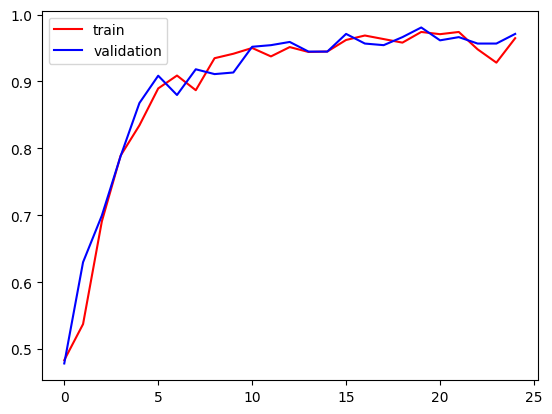

In [146]:
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

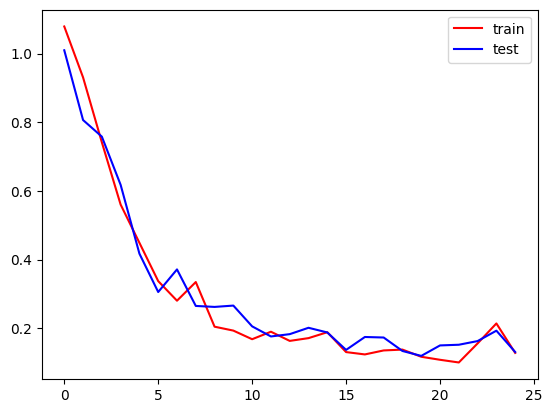

In [147]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='test')
plt.legend()
plt.show()

In [12]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 34ms/step


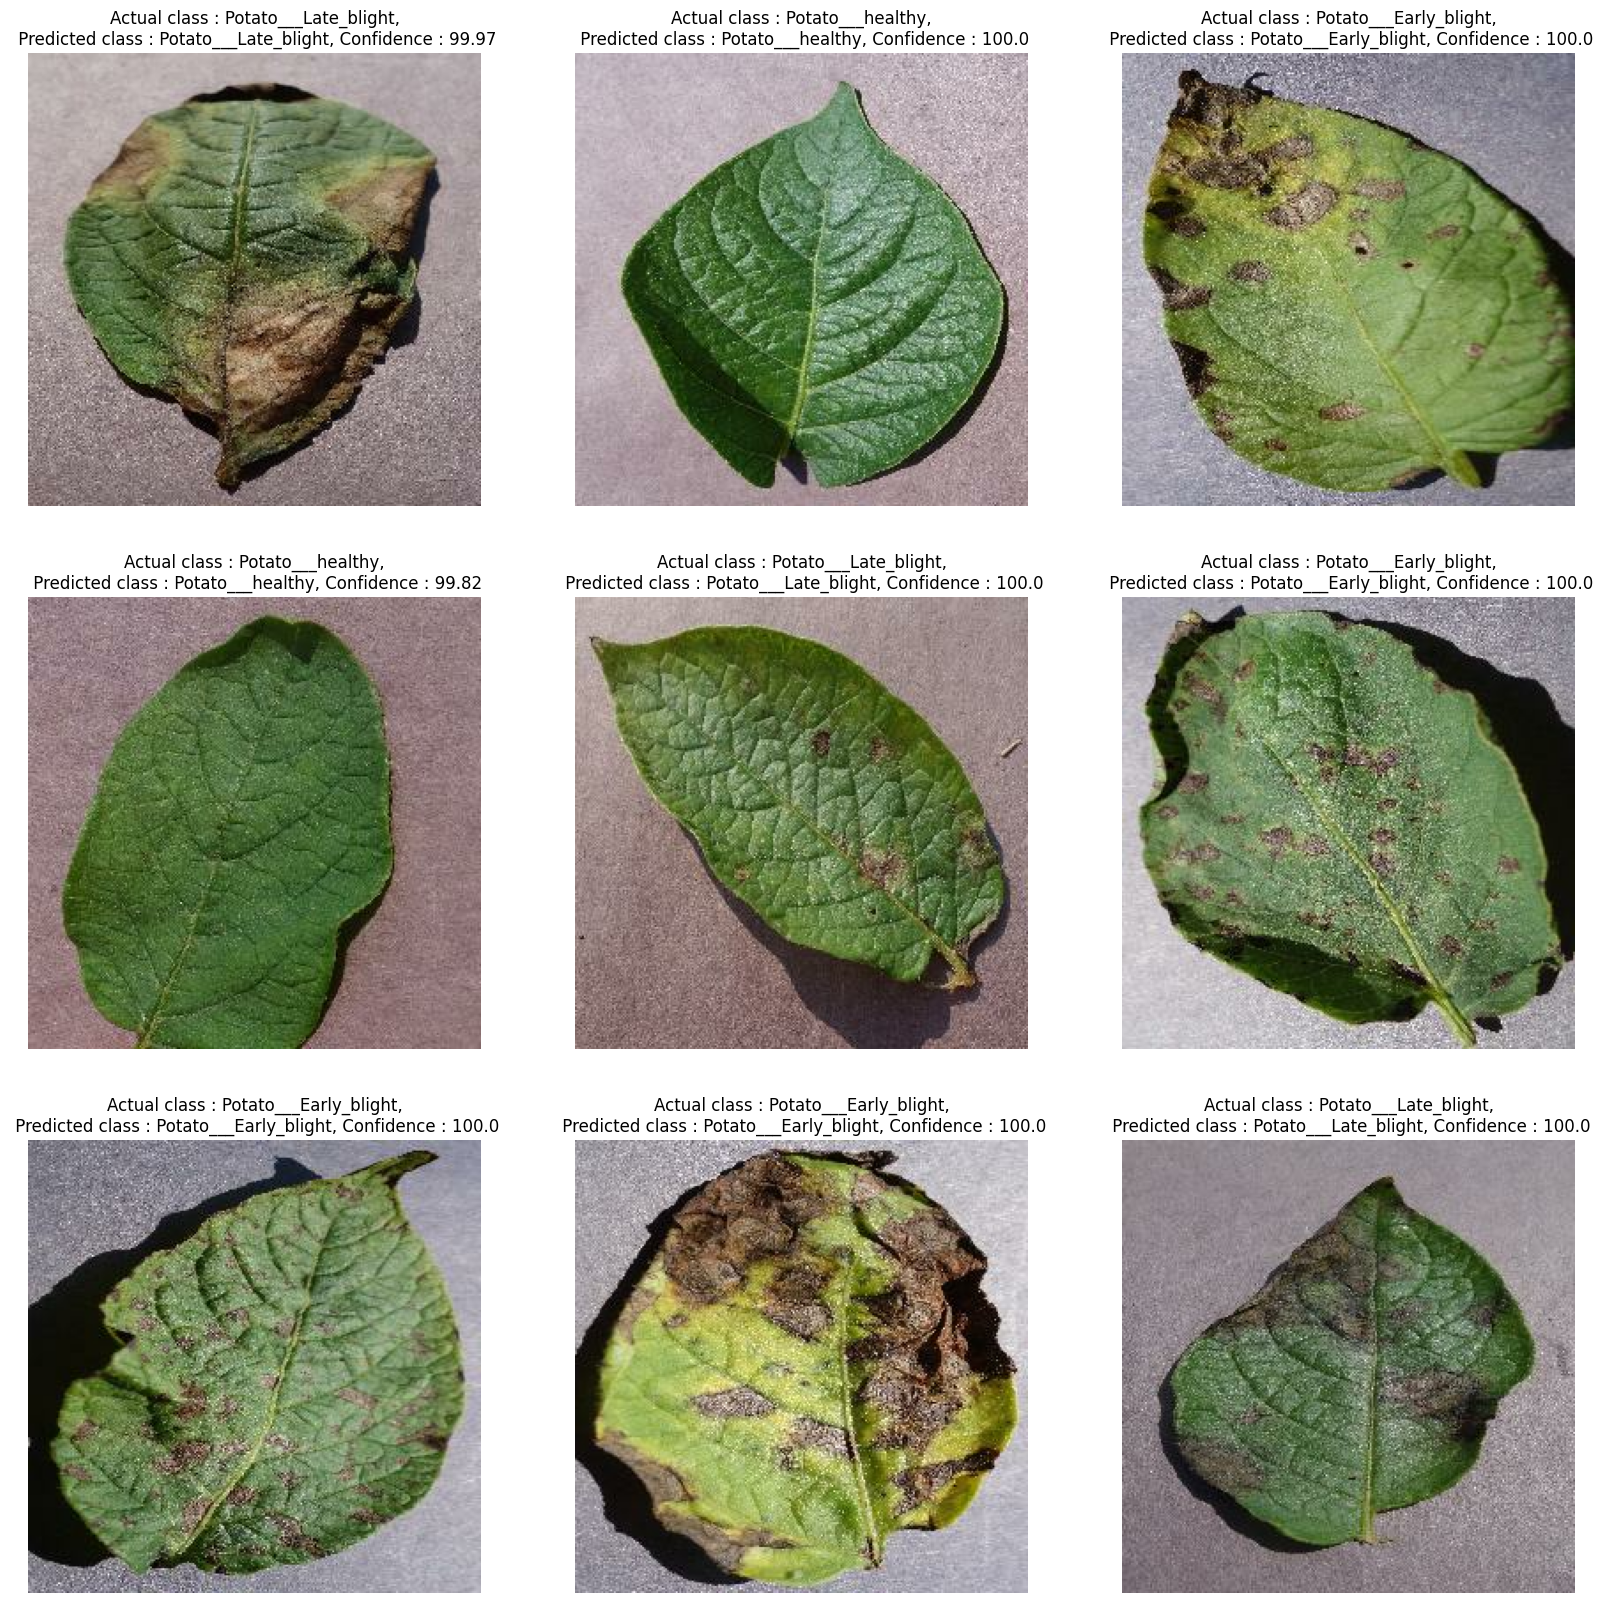

In [13]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, (i+1))
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, image_batch[i].numpy())
        plt.title(f'Actual class : {class_names[label_batch[i].numpy()]},\n Predicted class : {predicted_class}, Confidence : {confidence}')
        plt.axis('off')
plt.show()

In [14]:
def evaluate_model(model):
    y_true = []
    y_pred = []
    for image_batch, label_batch in test_ds:
        predictions = model.predict(image_batch)
        prediction_labels = np.argmax(predictions, axis=1)
        y_true.append(label_batch.numpy())
        y_pred.append(prediction_labels)
        
    y_true_flat = np.concatenate(y_true)
    y_pred_flat = np.concatenate(y_pred)
    
    print("Classification Report : ")
    print(classification_report(y_true_flat, y_pred_flat, target_names=class_names))
    print("Confusion Matrix : ")
    print(confusion_matrix(y_true_flat, y_pred_flat))
    
    scores = model.evaluate(test_ds)
    print(f"Overall Loss : {scores[0]}, Overall Accuracy : {scores[1]}")

In [15]:
evaluate_model(model)

1/1 [==============================] - 0s 46ms/step
Classification Report : 
                       precision    recall  f1-score   support

Potato___Early_blight       0.99      1.00      1.00       106
 Potato___Late_blight       1.00      0.97      0.99       102
     Potato___healthy       0.92      1.00      0.96        24

             accuracy                           0.99       232
            macro avg       0.97      0.99      0.98       232
         weighted avg       0.99      0.99      0.99       232

Confusion Matrix : 
[[106   0   0]
 [  1  99   2]
 [  0   0  24]]
8/8 [==============================] - 1s 38ms/step - loss: 0.0300 - accuracy: 0.9871
Overall Loss : 0.030046697705984116, Overall Accuracy : 0.9870689511299133


## Model Saving

In [152]:
import os
max_version = max([int(i) for i in os.listdir('./models') + [0]])+1
model.save(f'./models/{max_version}')